In [1]:
from snowflake.snowpark import Session
import tomllib
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
with open("/root/UMBC-DATA606-Capstone/snowflakecli.toml", "rb") as f:
    
    config = tomllib.load(f)  # Python >=3.11

# Get wallet classification connection details
wallet_classification_config = config["connections"]["wallet_classification"]

# Replace placeholders with environment variable values
conn_params = {k: os.path.expandvars(v) for k, v in wallet_classification_config.items()}

# Create Snowpark session
session = Session.builder.configs(conn_params).create()

# Test connection
print("Current Snowflake Role:", session.sql("SELECT CURRENT_ROLE()").collect()[0][0])

Current Snowflake Role: ACCOUNTADMIN


In [4]:
session.use_schema("RAW_ANALYTICS")

In [5]:
df=session.table("WALLET_CLASSIFICATION")
df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ADDRESS"                                    |"ACTIVE_DAYS"  |"TOTAL_TX_COUNT"  |"TOTAL_INCOMING_TX"  |"TOTAL_OUTGOING_TX"  |"LIFETIME_RECEIVED_LTC"  |"LIFETIME_SENT_LTC"  |"TOTAL_FEES_PAID_LTC"  |"CURRENT_BALANCE_LTC"  |"AVG_TX_PER_DAY"  |"AVG_RECEIVED_PER_DAY"  |"AVG_SENT_PER_DAY"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|ltc1qdpdkuglshjqd97q0l8xq2sn8tntq3xck78zec8  |1              |1                 |1                    |0                    |10000     

In [6]:
#%pip install "snowflake-connector-python[pandas]"
df_wallet=df.to_pandas()
df_wallet.head()

,ADDRESS,ACTIVE_DAYS,TOTAL_TX_COUNT,TOTAL_INCOMING_TX,TOTAL_OUTGOING_TX,LIFETIME_RECEIVED_LTC,LIFETIME_SENT_LTC,TOTAL_FEES_PAID_LTC,CURRENT_BALANCE_LTC,AVG_TX_PER_DAY,AVG_RECEIVED_PER_DAY,AVG_SENT_PER_DAY
0,ltc1qvt25uyvpp6u6dggmrkx8j3e0264ye7lv45a6kd,1,2,1,1,10000,10000,3280,10000.0,2.0,1.000000e+04,1.000000e+04
1,MJLG9VW6kKBqosjkR95qmQYXUn8pyB3kcY,2,3,2,1,20000,10000,5510,10000.0,1.5,1.000000e+04,5.000000e+03
2,ltc1qa2kl83u023kqlxk05rsjqqa5epnp6e5fuw7jlm,1,3,2,1,28610437147,28610427147,1130,10000.0,3.0,2.861044e+10,2.861043e+10
3,ltc1qyv4yf3wtk9crsz8lj7ymhrk5kqca3k5xkctmx7,1,1,1,0,50000,0,0,50000.0,1.0,5.000000e+04,0.000000e+00
4,ltc1qsmjxrvqk67jm4xte4f78q9qck2pv0f9jpj6vsp,1,1,1,0,50000,0,0,50000.0,1.0,5.000000e+04,0.000000e+00


In [15]:
features = [
    "ACTIVE_DAYS",
    "TOTAL_TX_COUNT",
    "TOTAL_OUTGOING_TX",
    "LIFETIME_SENT_LTC",
    "LIFETIME_RECEIVED_LTC",
    "CURRENT_BALANCE_LTC",
    "AVG_SENT_PER_DAY",
    "AVG_RECEIVED_PER_DAY"
]

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

X = df_wallet_clean[features]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cluster into 3 groups
kmeans = KMeans(n_clusters=3, random_state=42)
df_wallet_clean['cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
df_wallet_clean.groupby('cluster')[features].mean().round(2)
cluster_map = {
    0: 'High Activity',
    1: 'Low Activity',
    2: 'Dormant'
}
df_wallet_clean['wallet_category'] = df_wallet_clean['cluster'].map(cluster_map)


         ACTIVE_DAYS  TOTAL_TX_COUNT  TOTAL_OUTGOING_TX  LIFETIME_SENT_LTC  \
cluster                                                                      
0               1.11            3.42               1.35       5.078962e+10   
1               2.00         6237.00            2976.00       4.046773e+15   
2               1.00            1.00               0.00       0.000000e+00   

         LIFETIME_RECEIVED_LTC  CURRENT_BALANCE_LTC  AVG_SENT_PER_DAY  \
cluster                                                                 
0                 5.185209e+10         1.701296e+09      4.720628e+10   
1                 4.261232e+15         5.586199e+13      2.023387e+15   
2                 3.400320e+05         2.205009e+14      0.000000e+00   

         AVG_RECEIVED_PER_DAY  
cluster                        
0                4.795513e+10  
1                2.130616e+15  
2                3.400320e+05  


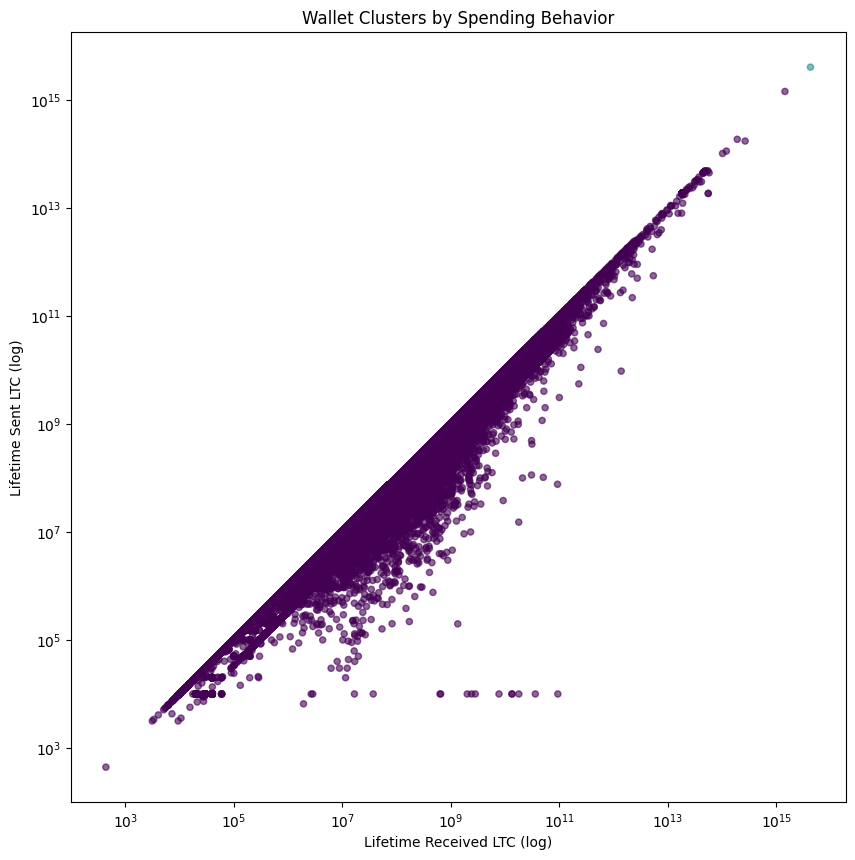

In [20]:
import matplotlib.pyplot as plt
import numpy as np

x = df_wallet_clean['LIFETIME_RECEIVED_LTC']
y = df_wallet_clean['LIFETIME_SENT_LTC']
c = df_wallet_clean['cluster']

plt.figure(figsize=(10,10))
plt.scatter(x, y, c=c, cmap='viridis', alpha=0.6, s=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Lifetime Received LTC (log)")
plt.ylabel("Lifetime Sent LTC (log)")
plt.title("Wallet Clusters by Spending Behavior")

plt.show()
